# CSF

In this experiment we will be obtaining the CSFs (Achromatic, Red-Green and Yellow-Blue) of PerceptNet. To do this we will generate tests with fixed frequencies and varying contrasts.

## Importing libraries

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import get_file
import cv2

from perceptnet.networks import PerceptNet
from perceptualtests.color_matrices import *
from utils import *

## Creating the images

In [3]:
# f_tests = np.array([2, 4, 8, 16, 32])
f_tests = np.array([1, 2, 4, 8, 16, 30])
num_rows, num_cols = 256, 256
num_frames = 1
fs = 64 # 6H -> 40 
L0 = 40 #cd/m2
sigma = num_rows/(fs*4)
c_noises = [0.1]#0.1*np.linspace(0,1,8)

In [4]:
[x,y,t,fx,fy,ft] = spatio_temp_freq_domain(num_rows, num_cols, num_frames, fs, fs, num_frames)
x0 = np.max(x)/2
y0 = np.max(y)/2

/media/disk/users/vitojor/miniconda3/envs/tf26/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755898319/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
## Gaussiana para la ventana
g = np.exp(-((x-x0)**2)/sigma**2-((y-y0)**2)/sigma**2)

In [6]:
def gaussian_window(x, y, sigma):
    """
    Defines a Gaussian window over the domain (x, y).
    """
    x0, y0 = np.max(x)/2, np.max(y)/2
    return np.exp(-((x-x0)**2)/sigma**2-((y-y0)**2)/sigma**2)

## Gabors

In [7]:
# Noisy gabors: noise with same same frequency and orientation as the test, change the contrast

# test_2 = np.zeros((num_rows, num_cols, 3, len(f_tests), len(c_tests), len(c_noises)))

# color_test = np.array([1, 0, 0])
color_noise = np.array([1, 0, 0])[None,:]
delta_angle = 180 
angle = 0
delta_f = f_tests/2

gabors_atd = np.empty(shape=(len(f_tests),len(c_noises),num_rows,num_cols,3))
gabors = np.empty(shape=(len(f_tests),len(c_noises),num_rows,num_cols,3))
for l, f_test in enumerate(f_tests):
    fm = f_test - delta_f[l]
    fM = f_test + delta_f[l]
    # nx, nf, F_noise = noise(fx, fy, fm, fM, angle, delta_angle)
    nx = np.sin(2*np.pi*f_test*x)
    nx = nx*g + L0
    
    for j, c_noise in enumerate(c_noises):
        nx2 = control_lum_contrast(nx + L0, L0, c_noise)
        nx2 = nx2[:,:,None]@color_noise
        gabors_atd[l,j,:,:,:] = nx2
        nx2 = nx2@Matd2xyz.T@Mxyz2ng.T
        if nx2.min()<0:
            print(f_test, (nx2<0).sum())
        nx2 = np.sqrt(nx2)
        gabors[l,j,:,:,:] = nx2
gabors.shape, gabors_atd.shape

((6, 1, 256, 256, 3), (6, 1, 256, 256, 3))

In [8]:
def create_gabors_gs(f_tests = np.array([1, 2, 4, 8, 16, 30]),
                     num_rows = 256, 
                     num_cols = 256,
                     num_frames = 1,
                     fs = 64,
                     L0 = 40,
                     c_noises = [0.1],
                     color_noise = np.array([1, 0, 0])[None,:],
                     delta_angle = 180,
                     angle = 0, #rad
                     phase = 0,
                     gs = None,
                     **kwargs):
                     
    [x,y,t,fx,fy,ft] = spatio_temp_freq_domain(num_rows, num_cols, num_frames, fs, fs, num_frames)
    x0 = np.max(x)/2
    y0 = np.max(y)/2

    if gs is None:
        gs = np.ones_like(x)
    elif callable(gs):
        gs = gs(x, y, **kwargs)

    sigma = num_rows/(fs*4)
    delta_f = f_tests/2

    gabors_atd = np.empty(shape=(len(f_tests),len(c_noises),num_rows,num_cols,3))
    gabors = np.empty(shape=(len(f_tests),len(c_noises),num_rows,num_cols,3))
    for l, f_test in enumerate(f_tests):
        fm = f_test - delta_f[l]
        fM = f_test + delta_f[l]
        nx = np.sin(2*np.pi*(f_test*np.cos(angle)*x+f_test*np.sin(angle)*y) + phase)
        nx = nx*gs + L0
        
        for j, c_noise in enumerate(c_noises):
            nx2 = control_lum_contrast(nx + L0, L0, c_noise) - L0
            nx2 = nx2[:,:,None]@color_noise
            nx2[:,:,0] = nx2[:,:,0] + L0
            gabors_atd[l,j,:,:,:] = nx2
            nx2 = nx2@Matd2xyz.T@Mxyz2ng.T
            if nx2.min()<0:
                print(f_test, (nx2<0).sum())
            nx2 = np.sqrt(nx2)
            gabors[l,j,:,:,:] = nx2
    
    return gabors_atd.squeeze(), gabors.squeeze()

In [9]:
def create_noises(f_tests = np.array([1, 2, 4, 8, 16, 30]),
                  num_rows = 256, 
                  num_cols = 256,
                  num_frames = 1,
                  fs = 64,
                  L0 = 40,
                  c_noises = [0.1],
                  color_noise = np.array([1, 0, 0])[None,:],
                  delta_angle = 180,
                  angle = 0,
                  gs = None,
                  **kwargs):

    [x,y,t,fx,fy,ft] = spatio_temp_freq_domain(num_rows, num_cols, num_frames, fs, fs, num_frames)
    x0 = np.max(x)/2
    y0 = np.max(y)/2

    if gs is None:
        gs = np.ones_like(x)
    elif callable(gs):
        gs = gs(x, y, **kwargs)

    delta_f = f_tests/4

    noises_atd = np.empty(shape=(len(f_tests),len(c_noises),num_rows,num_cols,3))
    noises = np.empty(shape=(len(f_tests),len(c_noises),num_rows,num_cols,3))
    for l, f_test in enumerate(f_tests):
        fm = f_test - delta_f[l]
        fM = f_test + delta_f[l]
        nx, nf, F_noise = noise(fx, fy, fm, fM, angle, delta_angle)
        nx = nx*gs
        
        for j, c_noise in enumerate(c_noises):
            nx2 = control_lum_contrast(nx + L0, L0, c_noise) - L0
            nx2 = nx2[:,:,None]@color_noise
            nx2[:,:,0] = nx2[:,:,0] + L0
            noises_atd[l,j,:,:,:] = nx2
            nx2 = nx2@Matd2xyz.T@Mxyz2ng.T
            nx2 = np.sqrt(nx2)
            noises[l,j,:,:,:] = nx2
    return noises_atd.squeeze(), noises.squeeze()

In [10]:
def create_background(f_tests = np.array([1, 2, 4, 8, 16, 30]),
                      num_rows = 256, 
                      num_cols = 256,
                      num_frames = 1,
                      fs = 64,
                      L0 = 40,
                      c_noises = [0.1],
                      color_noise = np.array([1, 0, 0])[None,:],
                      delta_angle = 180,
                      angle = 0,
                      gs = None,
                      **kwargs):

    [x,y,t,fx,fy,ft] = spatio_temp_freq_domain(num_rows, num_cols, num_frames, fs, fs, num_frames)
    x0 = np.max(x)/2
    y0 = np.max(y)/2

    if gs is None:
        gs = np.ones_like(x)
    elif callable(gs):
        gs = gs(x, y, **kwargs)

    delta_f = f_tests/4

    noises_atd = np.empty(shape=(len(f_tests),len(c_noises),num_rows,num_cols,3))
    noises = np.empty(shape=(len(f_tests),len(c_noises),num_rows,num_cols,3))
    for l, f_test in enumerate(f_tests):
        fm = f_test - delta_f[l]
        fM = f_test + delta_f[l]
        nx, nf, F_noise = noise(fx, fy, fm, fM, angle, delta_angle)
        nx = nx*gs
        
        for j, c_noise in enumerate(c_noises):
            nx2 = control_lum_contrast(nx + L0, L0, c_noise) - L0
            nx2 = nx2[:,:,None]@color_noise
            nx2[:,:,0] = nx2[:,:,0] + L0
            noises_atd[l,j,:,:,:] = nx2
            nx2 = nx2@Matd2xyz.T@Mxyz2ng.T
            nx2 = np.sqrt(nx2)
            noises[l,j,:,:,:] = nx2
    return noises_atd.squeeze(), noises.squeeze()

In [11]:
gabors_atd, gabors = create_gabors_gs(f_tests=f_tests,
                                      num_rows = 256, 
                                      num_cols = 256,
                                      fs = 64,
                                      L0 = L0,
                                      c_noises = c_noises,
                                      color_noise = np.array([1, 0, 0])[None,:],
                                      gs = g)
gabors.shape, gabors_atd.shape

((6, 256, 256, 3), (6, 256, 256, 3))

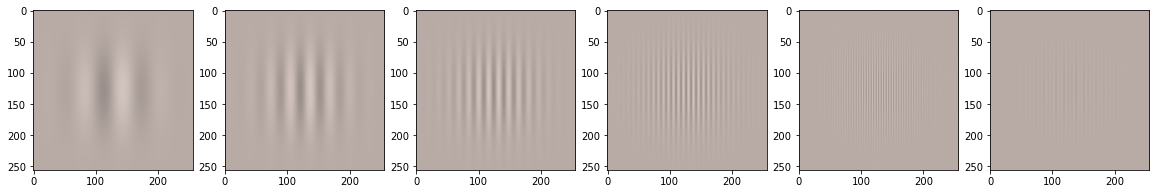

In [12]:
fig, ax = plt.subplots(1,len(gabors), figsize=(20, 9))

for i, gabor in enumerate(gabors):
    ax[i].imshow(gabor)
plt.show()

# Noise

In [13]:
noises_atd, noises = create_noises(f_tests=f_tests,
                                   num_rows = 256, 
                                   num_cols = 256,
                                   fs = 64,
                                   L0 = L0,
                                   c_noises = c_noises,
                                   color_noise = np.array([1, 0, 0])[None,:],
                                   gs = g)
noises.shape, noises_atd.shape

((6, 256, 256, 3), (6, 256, 256, 3))

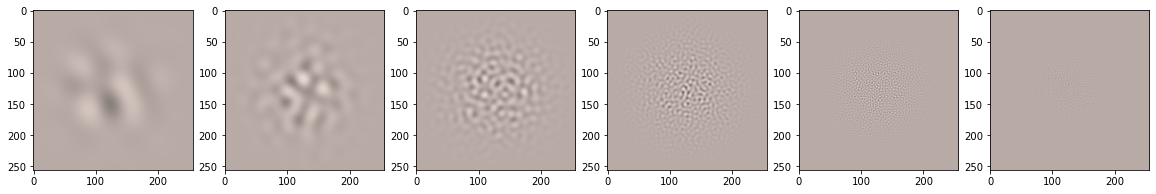

In [14]:
fig, ax = plt.subplots(1,len(noises), figsize=(20, 9))

for i, noise_ in enumerate(noises):
    ax[i].imshow(noise_)
plt.show()

## Passing the inputs through the network

In [15]:
weights_path = get_file(fname='perceptnet_rgb.h5',
                        origin='https://github.com/Jorgvt/perceptnet/releases/download/Weights/final_model_rgb.h5')

In [16]:
model = PerceptNet(kernel_initializer='ones', gdn_kernel_size=1, learnable_undersampling=False)
model.build(input_shape=(None, 384, 512, 3))
model.load_weights(weights_path)

2022-06-15 10:35:18.519441: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5435 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN Black, pci bus id: 0000:83:00.0, compute capability: 3.5


We can do the processing on the fly to save memory:

> The output of each image must be compared to the output produced by the image where the signal's contrast is 0, so we will have to always compare to the first element in each batch.

In [17]:
def get_readouts(model, imgs):
    ## Pass the through the model
    outputs = model.predict(imgs)

    ## Get the readouts as the distance to the lowest freq image
    readouts = (outputs-outputs[0])**2
    readouts = np.sqrt(np.sum(readouts.reshape(imgs.shape[0],-1), axis=-1))
    
    ## Return readouts
    return readouts

In [18]:
def get_readouts_mean(model, imgs):
    ## Pass the through the model
    outputs = model.predict(imgs)

    ## Calculate the means per channel
    outputs = outputs.mean(axis=(1,2))
    
    ## Get the readouts as the distance to the lowest freq image
    readouts = (outputs-outputs[0])**2
    readouts = np.sqrt(np.sum(readouts.reshape(imgs.shape[0],-1), axis=-1))
    
    ## Return readouts
    return readouts

In [19]:
def plot_results(results, color='k'):
    alphas = np.linspace(0.2,1,len(results))
    markers = ['o', '*', '^', 's', '.', '1', 'P', 'x']
    for i, (c_noise, readouts) in enumerate(results.items()):
        plt.plot(contrasts, readouts, color, alpha=alphas[i], marker=markers[i], label=f'Freq (Noise) = {c_noise:.2f}')
        plt.xlabel('Contrast (Signal)')
        plt.ylabel('Visibility')

In [20]:
def plot_results_2(results, color='k'):
    alphas = np.linspace(0.2,1,len(results))
    markers = ['o', '*', '^', 's', '.']
    for i, (delta_f, readouts) in enumerate(results.items()):
        plt.plot(contrasts, readouts, color, alpha=alphas[i], marker=markers[i], label=f'Delta Freq = {delta_f:.2f}')
        plt.xlabel('Contrast (Signal)')
        plt.ylabel('Visibility')

In [21]:
def plot_csf(results, color='k', xscale='log', yscale='log'):
    freqs, sens = [], []
    for freq, vis in results.items():
        freqs.append(freq)
        sens.append(vis[1])
    plt.plot(freqs, sens, color, marker='o')
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.title("CSF")
    plt.xlabel("Frequency (cpd)")
    plt.ylabel("Sensitivity")

Generate background:

In [23]:
color_noise = np.array([1, 0, 0])[None,:]
c_noise = 0.1

In [31]:
background = control_lum_contrast(gabors_atd[0,:,:,0] + L0, L0, 0)
background = background[:,:,None]@color_noise
background = background@Matd2xyz.T@Mxyz2ng.T
background = np.sqrt(background)

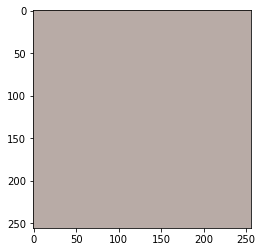

In [32]:
plt.imshow(background)
plt.show()

In [33]:
pred_background = model.predict(background[None,:,:,:])
background.shape, pred_background.shape

((256, 256, 3), (1, 64, 64, 128))

## Gabors

In [36]:
pred_gabors = model.predict(gabors)
vis_gabors = (pred_gabors-pred_background)**2
vis_gabors = np.sqrt(np.sum(vis_gabors.reshape(gabors.shape[0],-1), axis=-1))
vis_gabors

array([ 2.5422626,  5.998555 ,  7.5308337, 10.692825 ,  4.518719 ,
        5.687723 ], dtype=float32)

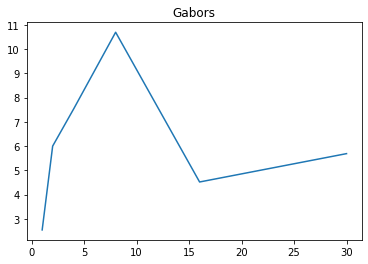

In [37]:
plt.figure()
plt.plot(f_tests, vis_gabors)
plt.title('Gabors')
plt.show()

### Iterations

In [38]:
freqs = np.linspace(0.1, 30, 40)[1:]
iterations = 7
visses_gabors, visses_gabors_rot, visses_noises = [], [], []
rotations = []
for i in range(iterations):
    ## Generate gabors
    gabors_atd, gabors = create_gabors_gs(f_tests=freqs,
                                          phase=np.random.uniform(0, 2*np.pi),
                                          num_rows = 256, 
                                          num_cols = 256,
                                          fs = 64,
                                          L0 = L0,
                                          c_noises = c_noises,
                                          color_noise = np.array([0, 0, 1])[None,:],
                                          gs = g)
    rotation = np.random.uniform(0, 2*np.pi)
    gabors_atd_rot, gabors_rot = create_gabors_gs(f_tests=freqs,
                                          phase=np.random.uniform(0, 2*np.pi),
                                          angle=rotation,
                                          num_rows = 256, 
                                          num_cols = 256,
                                          fs = 64,
                                          L0 = L0,
                                          c_noises = c_noises,
                                          color_noise = np.array([0, 0, 1])[None,:],
                                          gs = g)
    ## Generate noises
    noises_atd, noises = create_noises(f_tests=freqs,
                                       L0 = L0,
                                       c_noises = c_noises,
                                       color_noise = np.array([0, 0, 1])[None,:],
                                       gs = g)
    ## Get readouts
    pred_gabors = model.predict(gabors)
    vis_gabors = (pred_gabors-pred_background)**2
    vis_gabors = np.sqrt(np.sum(vis_gabors.reshape(gabors.shape[0],-1), axis=-1))

    pred_gabors_rot = model.predict(gabors_rot)
    vis_gabors_rot = (pred_gabors_rot-pred_background)**2
    vis_gabors_rot = np.sqrt(np.sum(vis_gabors_rot.reshape(gabors_rot.shape[0],-1), axis=-1))

    pred_noises = model.predict(noises)
    vis_noises = (pred_noises-pred_background)**2
    vis_noises = np.sqrt(np.sum(vis_noises.reshape(noises.shape[0],-1), axis=-1))

    ## Store them
    visses_gabors.append(vis_gabors)
    visses_gabors_rot.append(vis_gabors_rot)
    rotations.append(rotation)
    visses_noises.append(vis_noises)
np.shape(visses_gabors), np.shape(visses_gabors_rot), np.shape(visses_noises)

/tmp/ipykernel_22172/3766427020.py:39: RuntimeWarning: invalid value encountered in sqrt
  nx2 = np.sqrt(nx2)


((7, 39), (7, 39), (7, 39))

#### Plot iterations

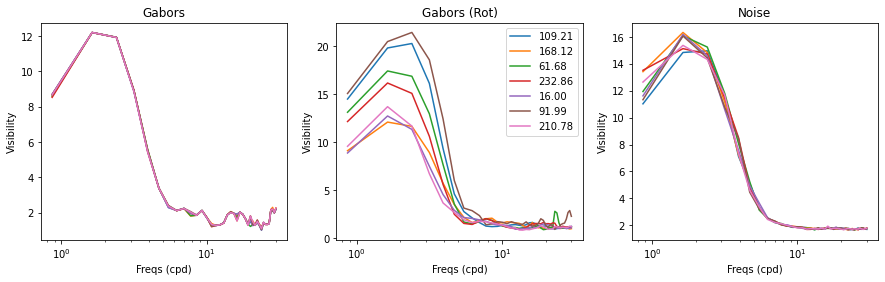

In [39]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
for vis_gabor in visses_gabors:
    plt.plot(freqs, vis_gabor)
plt.title('Gabors')
plt.xlabel('Freqs (cpd)')
plt.ylabel('Visibility')
plt.xscale('log')

plt.subplot(1,3,2)
for i,vis_gabor_rot in enumerate(visses_gabors_rot):
    plt.plot(freqs, vis_gabor_rot, label=f'{rotations[i]*180/np.pi:.2f}')
plt.title('Gabors (Rot)')
plt.xlabel('Freqs (cpd)')
plt.ylabel('Visibility')
plt.xscale('log')
plt.legend()

plt.subplot(1,3,3)
for vis_noise in visses_noises:
    plt.plot(freqs, vis_noise)
plt.title('Noise')
plt.xlabel('Freqs (cpd)')
plt.ylabel('Visibility')
plt.xscale('log')

plt.show()

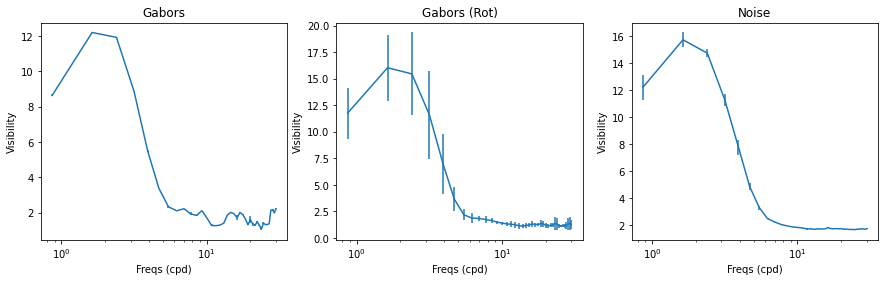

In [40]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.errorbar(freqs, np.mean(visses_gabors, axis=0), yerr=np.std(visses_gabors, axis=0))
plt.title('Gabors')
plt.xlabel('Freqs (cpd)')
plt.ylabel('Visibility')
plt.xscale('log')
# plt.yscale('log')

plt.subplot(1,3,2)
plt.errorbar(freqs, np.mean(visses_gabors_rot, axis=0), yerr=np.std(visses_gabors_rot, axis=0))
plt.title('Gabors (Rot)')
plt.xlabel('Freqs (cpd)')
plt.ylabel('Visibility')
plt.xscale('log')
# plt.yscale('log')

plt.subplot(1,3,3)
plt.errorbar(freqs, np.mean(visses_noises, axis=0), yerr=np.std(visses_noises, axis=0))
plt.title('Noise')
plt.xlabel('Freqs (cpd)')
plt.ylabel('Visibility')
plt.xscale('log')
# plt.ylim([3.5, 12.5])
# plt.yscale('log')

plt.show()

### Different angles

We'll now create gabors of interesting orientations to see if we can find any "preferred" orientations in the model.

In [44]:
freqs = np.linspace(0.1, 30, 40)[1:]
angles = np.linspace(0, 90, 5)*np.pi/180
iterations = 7
visses_gabors_rot = []
rotations = []
for angle in angles:
    for i in range(iterations):
        visses_gabors_rot_i = []
        ## Generate gabors
        gabors_atd_rot, gabors_rot = create_gabors_gs(f_tests=freqs,
                                                        num_rows = 256, 
                                                        num_cols = 256,
                                                        fs = 64,
                                                        L0 = L0,
                                                        c_noises = c_noises,
                                                        color_noise = np.array([1, 0, 0])[None,:],
                                                        gs = g,
                                                        phase=np.random.uniform(0, 2*np.pi),
                                                        angle=angle)
        ## Get readouts
        pred_gabors_rot = model.predict(gabors_rot)
        vis_gabors_rot = (pred_gabors_rot-pred_background)**2
        vis_gabors_rot = np.sqrt(np.sum(vis_gabors_rot.reshape(gabors_rot.shape[0],-1), axis=-1))
        ## Store them
        visses_gabors_rot_i.append(vis_gabors_rot)
    visses_gabors_rot.append(np.mean(visses_gabors_rot_i, axis=0))
np.shape(visses_gabors_rot)

(5, 39)

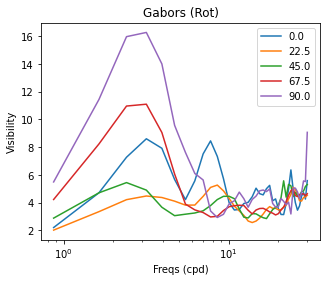

In [45]:
plt.figure(figsize=(5,4))

for i,vis_gabor_rot in enumerate(visses_gabors_rot):
    plt.plot(freqs, vis_gabor_rot, label=f'{angles[i]*180/np.pi}')
plt.title('Gabors (Rot)')
plt.xlabel('Freqs (cpd)')
plt.ylabel('Visibility')
plt.xscale('log')
plt.legend()

plt.show()

# Obtaining the three curves together

We've obtained the CSFs separatelly in each case, but it'd be more interesting to plot all of them in the same figure so that we can compare them and so:

In [65]:
def obtain_csf_iteratively(freqs, iterations, color_noise, background):
    visses_gabors, visses_gabors_rot, visses_noises = [], [], []
    rotations = []
    for i in range(iterations):
        ## Generate gabors
        gabors_atd, gabors = create_gabors_gs(f_tests=freqs,
                                            phase=np.random.uniform(0, 2*np.pi),
                                            num_rows = 256, 
                                            num_cols = 256,
                                            fs = 64,
                                            L0 = L0,
                                            c_noises = c_noises,
                                            color_noise = color_noise,
                                            gs = g)
        rotation = np.random.uniform(0, 2*np.pi)
        gabors_atd_rot, gabors_rot = create_gabors_gs(f_tests=freqs,
                                            phase=np.random.uniform(0, 2*np.pi),
                                            angle=rotation,
                                            num_rows = 256, 
                                            num_cols = 256,
                                            fs = 64,
                                            L0 = L0,
                                            c_noises = c_noises,
                                            color_noise = color_noise,
                                            gs = g)
        ## Generate noises
        noises_atd, noises = create_noises(f_tests=freqs,
                                        L0 = L0,
                                        c_noises = c_noises,
                                        color_noise = color_noise,
                                        gs = g)
        ## Get readouts
        pred_gabors = model.predict(gabors)
        vis_gabors = (pred_gabors-pred_background)**2
        vis_gabors = np.sqrt(np.sum(vis_gabors.reshape(gabors.shape[0],-1), axis=-1))

        pred_gabors_rot = model.predict(gabors_rot)
        vis_gabors_rot = (pred_gabors_rot-pred_background)**2
        vis_gabors_rot = np.sqrt(np.sum(vis_gabors_rot.reshape(gabors_rot.shape[0],-1), axis=-1))

        pred_noises = model.predict(noises)
        vis_noises = (pred_noises-pred_background)**2
        vis_noises = np.sqrt(np.sum(vis_noises.reshape(noises.shape[0],-1), axis=-1))

        ## Store them
        visses_gabors.append(vis_gabors)
        visses_gabors_rot.append(vis_gabors_rot)
        rotations.append(rotation)
        visses_noises.append(vis_noises)
        
    ## Return them as np.arrays
    return np.array(visses_gabors), np.array(visses_gabors_rot), np.array(visses_noises)

In [50]:
freqs = np.linspace(0.1, 30, 40)[1:]
iterations = 7

In [66]:
visses_all = {
    'Achromatic': obtain_csf_iteratively(freqs=freqs, iterations=iterations, color_noise=np.array([1, 0, 0])[None,:], background=background),
    'Red-Green': obtain_csf_iteratively(freqs=freqs, iterations=iterations, color_noise=np.array([0, 1, 0])[None,:], background=background),
    'Yellow-Blue': obtain_csf_iteratively(freqs=freqs, iterations=iterations, color_noise=np.array([0, 0, 1])[None,:], background=background),
}

/tmp/ipykernel_22172/3766427020.py:39: RuntimeWarning: invalid value encountered in sqrt
  nx2 = np.sqrt(nx2)


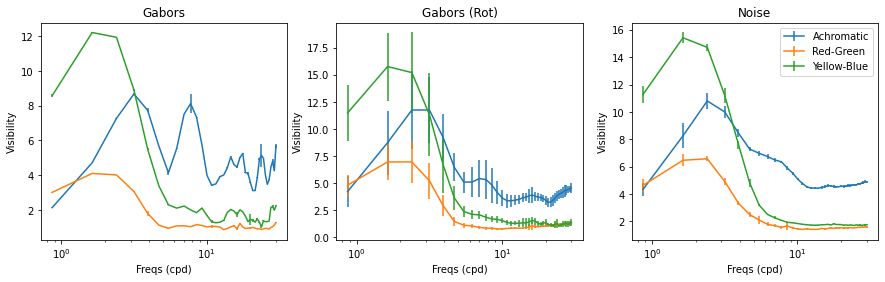

In [70]:
plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.errorbar(freqs, np.mean(visses_all['Achromatic'][0], axis=0), yerr=np.std(visses_all['Achromatic'][0], axis=0), label='Achromatic')
plt.errorbar(freqs, np.mean(visses_all['Red-Green'][0], axis=0), yerr=np.std(visses_all['Red-Green'][0], axis=0), label='Red-Green')
plt.errorbar(freqs, np.mean(visses_all['Yellow-Blue'][0], axis=0), yerr=np.std(visses_all['Yellow-Blue'][0], axis=0), label='Yellow-Blue')
plt.title('Gabors')
plt.xlabel('Freqs (cpd)')
plt.ylabel('Visibility')
plt.xscale('log')
# plt.yscale('log')

plt.subplot(1,3,2)
plt.errorbar(freqs, np.mean(visses_all['Achromatic'][1], axis=0), yerr=np.std(visses_all['Achromatic'][1], axis=0), label='Achromatic')
plt.errorbar(freqs, np.mean(visses_all['Red-Green'][1], axis=0), yerr=np.std(visses_all['Red-Green'][1], axis=0), label='Red-Green')
plt.errorbar(freqs, np.mean(visses_all['Yellow-Blue'][1], axis=0), yerr=np.std(visses_all['Yellow-Blue'][1], axis=0), label='Yellow-Blue')
plt.title('Gabors (Rot)')
plt.xlabel('Freqs (cpd)')
plt.ylabel('Visibility')
plt.xscale('log')
# plt.yscale('log')

plt.subplot(1,3,3)
plt.errorbar(freqs, np.mean(visses_all['Achromatic'][2], axis=0), yerr=np.std(visses_all['Achromatic'][2], axis=0), label='Achromatic')
plt.errorbar(freqs, np.mean(visses_all['Red-Green'][2], axis=0), yerr=np.std(visses_all['Red-Green'][2], axis=0), label='Red-Green')
plt.errorbar(freqs, np.mean(visses_all['Yellow-Blue'][2], axis=0), yerr=np.std(visses_all['Yellow-Blue'][2], axis=0), label='Yellow-Blue')
plt.title('Noise')
plt.xlabel('Freqs (cpd)')
plt.ylabel('Visibility')
plt.xscale('log')
# plt.ylim([3.5, 12.5])
# plt.yscale('log')

plt.legend()

plt.show()